# Attention!

In this chapter, we approach current state-of-the-art language modeling. Originally, many common tasks in language modeling such as classification or language translation processed text sequentially. For instance, word embeddings have been processed by recurrent neural networks (we did not discuss them in this course). These approaches struggled by issues arising due to the lack of memorizing long term dependencies and by numerical problems caused by vanishing gradients and can not be computed in parallel due to their recursive nature (leading to potentially long lasting training processes). While different approaches such as layer architectures (long-short-term-memory or gated recurrent unit layers) and attention mechanisms have been implemented in recurrent neural networks to overcome these issues, the presentation of the transformer network in the seminal paper [Attention is all you need](https://arxiv.org/abs/1706.03762) by Vaswani et al. in 2017 provided an approach which does not rely upon recursive processing of text sequences and implements an attention approach which enables the model to understand the context of human language. The transformer had a massive impact on all future language models which have been developed until today. 

The cell below shows its architecture. The full transformer model is an encoder decoder network. The encoder generates a numerical representation of text sequences which includes word embeddings that are aware of the word position in the sequence and its contextual meaning to the remaining words. The decoder is able to use this encoded text sequence to generate a new version, e.g., a translation of the original text into another language. Even though, the original paper has its major focus on language translation, the model architecture has been used to develop other models which can be used for a variety of other language modeling tasks. Roughly the new models can be divided into encoder, decoder and encoder-decoder models. Roughly speaking, encoder models are about finding representative embeddings of input text, decoder models are often used for generation of text and encoder-decoder models serve to concert one text sequence into another version of it, e.g., another language.

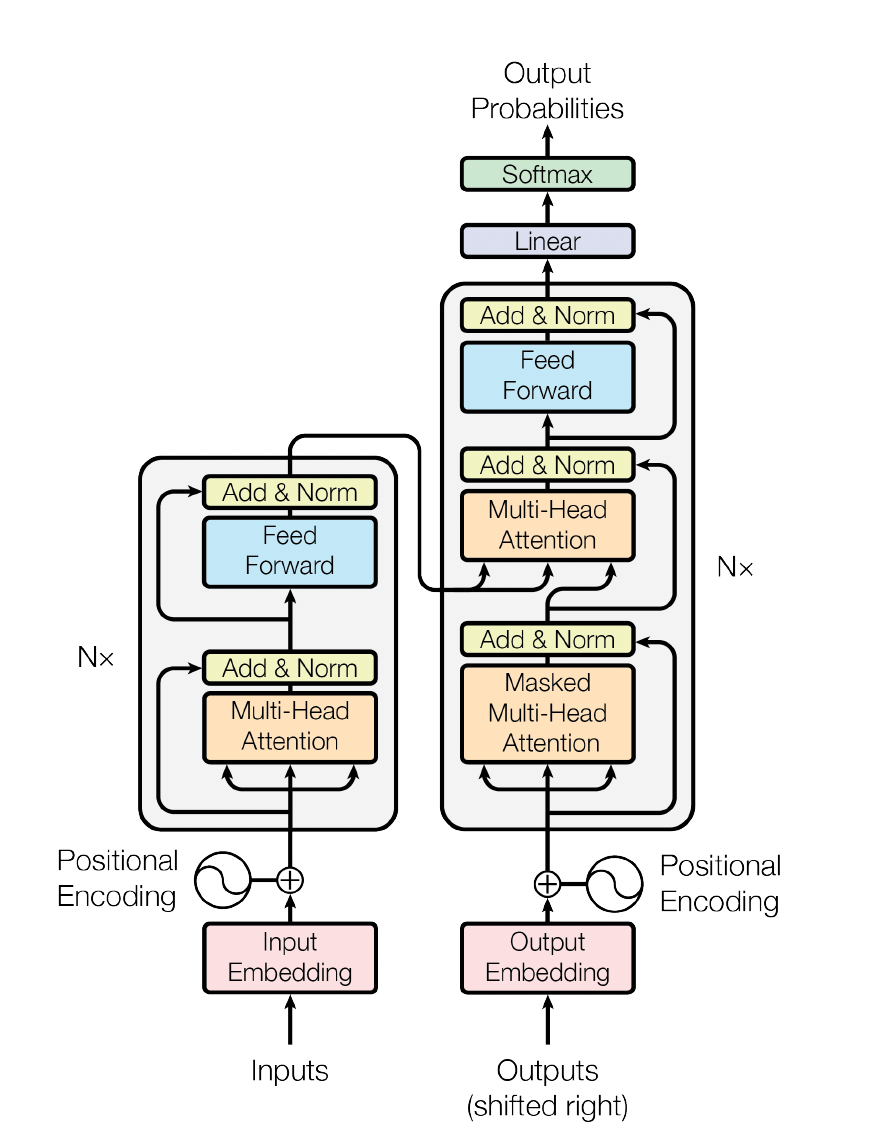

In [1]:
from IPython.display import Image
Image(filename='transformer.png', width=400) 

Two popular model families which evolved on the back of the transformer are [BERT](https://arxiv.org/abs/1810.04805) and [GPT](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf) models. BERT is an encoder model and GPT are decoder models. The aim for this course is to focus on BERT models as these can be used for common tasks in the financial domain such as financial sentiment classification, creating text embeddings (which can be used for topic modeling) or the identification of topic specific disclosure in financial reports. To achieve this goal, we discuss the encoder of the transformer in this section and focus on the BERT model in the next section. In comparison to neural network architectures discussed so far in this course, the transformer and its encoder are more more complex. The aim for course participants is two-fold for this section. 

1. Get an idea of the attention mechanism which is used in the model
2. Understand the dimensionality of the numerical text representation

I am going to explain the encoder in detail below, however, to not forget output these goals. To motivate yourself, you can take a look a these examples:

* [classification](https://huggingface.co/nateraw/bert-base-uncased-emotion)
* [text generation](https://huggingface.co/gpt2?text=My+name+is+Julien+and+I+like+to+play+with+my+friends.+I%27m+a+big+fan+of+the+game+and+I) 
* [question answering](https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad?context=My+name+is+Sarah+and+I+live+in+London&text=Where+do+I+live%3F)

All of them rely upon models which were developed after the introduction of the transformer model. You should already be familiar with the use of word and document embeddings, this means words and documents are represented by $p$-dimensional real valued vectors. The encoder of the transformer receives a sequence of $n$ tokens. The numerical representation of this sequence concatenates token embeddings row-wise. Thus, the input dimension for the transformer encoder is $n \times p$. The output of the encoder has the same dimension. However, from the input to the output, the numerical input representation is manipulated by different mathematical operations which depend on a large amount of model parameters that are going to be trained. Roughly, we may decompose the walk from input to output of the encoder into:

* input: transform words into word embeddings (parameters to be trained)
* positional information: added to the input word embeddings to differentiate the meaning of words, given they occur in different positions
* attention processing: add contextual meaning to input and position embeddings (this is done by parameters which need to be trained)
* add further flexibility to the contextualization by common neural networks layers (this is also done by parameters which need to be trained)

The last two bullet points are treated as a layer which means it can be repeated more often in the same way with different parameters. This enables the model to learn more complex linguistic relationships and demands more training examples as it raises the number of parameters. Furthermore, some technical aspects are added to this layer (residual connections and layer normalization) which are needed to enable and improve the training process. To me, it is most important that you get an idea about the attention mechanism of the model. From a practical point of view, you should become familiar with the output of the model and what it represents. Let us go step by step through data processing of the encoder.

## Word embeddings

First, the model starts with word embeddings. As for the Word2Vec model, we would make use of a word to index mapping which uses the row vector of an embedding matrix. Let us stick to the small text example of the previous chapters. Given our example corpus, we start with our word2index dictionary and the word embedding matrix $X$ in which every row represents a word embedding (we change the notation here from $W$ to $X$ to keep the notation more in line with the original paper) Let us assume we want to process the second sentence "I like to eat ice-cream" through the encoder of the transformer, the following matrix is how we start:

In [2]:
from gensim.utils import simple_preprocess
import numpy as np


raw_corpus = [
    "The dog would like a piece of the sandwich",
    "I like to eat ice-cream",
    "A dog is a good friend"
]

corpus = [simple_preprocess(doc, min_len = 1) for doc in raw_corpus]

word2index = dict()
idx = 0
for i, doc in enumerate(corpus):
    for word in doc:
        if word in word2index.keys():
            continue
        else:
            word2index[word] = idx
            idx += 1

# lexicon length
d = len(word2index)
# embedding dimension
p = 4
# randomly initialize word embeddings
np.random.seed(42)
X_all = np.random.randn(d, p)
# example sentence word indices
example_indices = [word2index[token] for token in corpus[1]]

# sequence length 
n = len(example_indices)
# word embeddings of example sentence
X = X_all[example_indices]

print("These are the index mappings of words:")
print(word2index)
print("")
print(f"Word embeddings of all words in the lexicon: \n {X_all} \n")
print(f"This is the second sentence represented by word indices: {example_indices} \n")
#print(example_indices)
print(f"Word embeddings of the example sentence, this is the first input to the encoder: \n {X}")

These are the index mappings of words:
{'the': 0, 'dog': 1, 'would': 2, 'like': 3, 'a': 4, 'piece': 5, 'of': 6, 'sandwich': 7, 'i': 8, 'to': 9, 'eat': 10, 'ice': 11, 'cream': 12, 'is': 13, 'good': 14, 'friend': 15}

Word embeddings of all words in the lexicon: 
 [[ 0.49671415 -0.1382643   0.64768854  1.52302986]
 [-0.23415337 -0.23413696  1.57921282  0.76743473]
 [-0.46947439  0.54256004 -0.46341769 -0.46572975]
 [ 0.24196227 -1.91328024 -1.72491783 -0.56228753]
 [-1.01283112  0.31424733 -0.90802408 -1.4123037 ]
 [ 1.46564877 -0.2257763   0.0675282  -1.42474819]
 [-0.54438272  0.11092259 -1.15099358  0.37569802]
 [-0.60063869 -0.29169375 -0.60170661  1.85227818]
 [-0.01349722 -1.05771093  0.82254491 -1.22084365]
 [ 0.2088636  -1.95967012 -1.32818605  0.19686124]
 [ 0.73846658  0.17136828 -0.11564828 -0.3011037 ]
 [-1.47852199 -0.71984421 -0.46063877  1.05712223]
 [ 0.34361829 -1.76304016  0.32408397 -0.38508228]
 [-0.676922    0.61167629  1.03099952  0.93128012]
 [-0.83921752 -0.309212

## Positional embeddings

To provide positional information for each word in the sentence, positional embeddings are calculated and added to the word embeddings. The original paper uses sine and cosine functions to determine the position embeddings. Let us iterate over the sequence and embedding dimensions by using the indices $i$ and $j$. Our example has sequence length $n = 6$ and embedding dimension $p = 4$. Thus, the word embedding matrix has dimension $6 \times 4$. The positional embedding matrix has the same dimension and both matrices are added. Iterating $i$ and $j$ starts at zero and values in the positional embedding matrix are generated by:

$$
P_{i, 2j} = \sin \left(\frac{i}{10000^{2i / p}} \right) \\
P_{i, 2j+1} = \cos \left(\frac{i}{10000^{2i / p}} \right) 
$$

This means even index values of the embedding index are determined using the sine function and uneven values are determined using the cosine. As a result each value of the positional embedding matrix is in the interval $[-1, 1]$ and the same word would be added to a different positional vector if it sits at a different position in a sequence. Note that other models also initialize the values in the positional embedding matrix randomly and learn its values during training (thus, positional encodings are trainable parameters). The cell below visualizes the positional embedding matrix for our example. Most importantly, you should note that each row corresponds to a word position in the sequence and these positional embeddings are different for different playes in the sequence

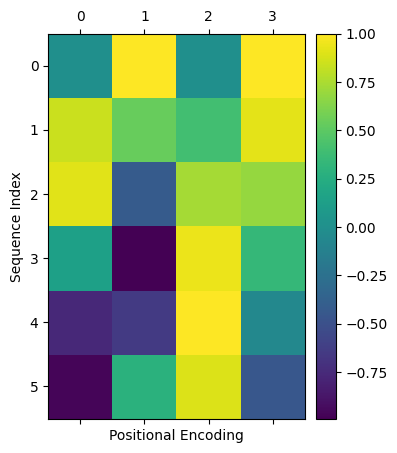

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# nice function taken from here: https://medium.com/towards-data-science/transformers-intuitively-and-exhaustively-explained-58a5c5df8dbb
#generating a positional encodings
def gen_positional_encodings(sequence_length, embedding_dimension):
    #creating an empty placeholder
    positional_encodings = np.zeros((sequence_length, embedding_dimension))

    #iterating over each element in the sequence
    for i in range(sequence_length):

        #calculating the values of this sequences position vector
        #as defined in section 3.5 of the attention is all you need
        #paper: https://arxiv.org/pdf/1706.03762.pdf
        for j in np.arange(int(embedding_dimension/2)):
            denominator = np.power(sequence_length, 2*j/embedding_dimension)
            positional_encodings[i, 2*j] = np.sin(i/denominator)
            positional_encodings[i, 2*j+1] = np.cos(i/denominator)

    return positional_encodings

#visualize the positional embedding matrix 
fig, ax = plt.subplots(figsize=(15,5))
ax.set_ylabel('Sequence Index')
ax.set_xlabel('Positional Encoding')
cax = ax.matshow(gen_positional_encodings(n, p))
fig.colorbar(cax, pad=0.01)
plt.show()

The word embedding and positional embedding matrix are added and with this matrix $\tilde{X} = X + P $ the first attention layer is entered. 

In [4]:
print(f"Word embedding matrix of the sentence:\n {X} \n")
P = gen_positional_encodings(n, p)
print(f"Positional embedding matrix of the sentence: \n {P} \n")
X_tilde = X + P
print(f"Word embedding matrix plus positional embedding matrix of the sentence: \n {X_tilde} \n")

Word embedding matrix of the sentence:
 [[-0.01349722 -1.05771093  0.82254491 -1.22084365]
 [ 0.24196227 -1.91328024 -1.72491783 -0.56228753]
 [ 0.2088636  -1.95967012 -1.32818605  0.19686124]
 [ 0.73846658  0.17136828 -0.11564828 -0.3011037 ]
 [-1.47852199 -0.71984421 -0.46063877  1.05712223]
 [ 0.34361829 -1.76304016  0.32408397 -0.38508228]] 

Positional embedding matrix of the sentence: 
 [[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.39700219  0.91781766]
 [ 0.90929743 -0.41614684  0.72875124  0.68477853]
 [ 0.14112001 -0.9899925   0.94071933  0.33918599]
 [-0.7568025  -0.65364362  0.9980664  -0.06215674]
 [-0.95892427  0.28366219  0.89136661 -0.4532831 ]] 

Word embedding matrix plus positional embedding matrix of the sentence: 
 [[-0.01349722 -0.05771093  0.82254491 -0.22084365]
 [ 1.08343326 -1.37297794 -1.32791564  0.35553013]
 [ 1.11816102 -2.37581696 -0.59943481  0.88163976]
 [ 0.87958659 -0.81862422  0.82507105  0.03808229]
 [-2.23532449 -1.

## Scaled dot-product attention

The information of words and their positions is given by $\tilde{X}$, however, the embeddings lack of an understanding how each word relates to the others in the sentence. To learn this, the model applies so called scaled dot-product multiple times over different layers in the transformer architecture. However, I think it is simpler to start studying this attention mechanism by itself, so let us assume we would use only one scaled dot-product attention mechanism and one layer for the model. To apply scaled dot-product attention to $\tilde{X}$, we use three parameter matrices: $W^Q, W^K, W^V$ (Note: scaled dot-product attention is defined without the use of paremeters, however, this is how it is going to be done later when using more of these attention mechanisms). Only in our simple scenario (one attention meachism, one layer), these matrices have the dimension $p \times p$, thus, after multiplying $\tilde{X}$ with each of these matrices, we receive the matrices $Q = \tilde{X} W^Q, K = \tilde{X} W^K, V = \tilde{X} W^V$ with dimension $n \times p$. They are called query, key and value embeddings and each row still relates to the word in the sentence. Next we calculate the attention matrix with:

$$
S = \text{softmax} \left( \frac{Q K^T}{\sqrt{p}} \right)
$$

While this may look meaningless or confusing to you at first sight, take a look at the $n \times n$ dimensional output of this calculation for our example.

In [5]:
from scipy.special import softmax

np.random.seed(42)
W_Q = np.random.randn(p, p)
W_K = np.random.randn(p, p)
W_V = np.random.randn(p, p)

Q = np.matmul(X_tilde, W_Q)
K = np.matmul(X_tilde, W_K)
attention_scores = np.matmul(Q, K.transpose()) / np.sqrt(p)
S = softmax(attention_scores, axis = 1)

print(f"Attention score matrix:\n {np.round(S, 2)}")

Attention score matrix:
 [[0.13 0.2  0.24 0.25 0.03 0.15]
 [0.05 0.01 0.01 0.02 0.88 0.03]
 [0.45 0.01 0.01 0.49 0.01 0.04]
 [0.16 0.08 0.19 0.25 0.16 0.16]
 [0.06 0.   0.   0.94 0.   0.  ]
 [0.11 0.07 0.04 0.76 0.   0.03]]


You can and should interpret the values in this matrix how much each word pays attention to each of the other words (itself included). If we add the words in the sentence as row and column labels as shown below, it may be more clear. Even though the values here do not stem from training (they are randomly drawn for this example), some seem plausible if they would come from a trained model. For instance, if we take a look at the row of the word "eat", we observe that the word would pay the most attention to itself (its weight is $0.27$), to the word "ice" (weight: $0.19$) and to the word "cream" (weight: $0.31$). This would make sense, because to understand a sentence about eating something it may be most important to understand which type of food is consumed. 

| |  i | like  | to | eat | ice | cream | 
|---|---|---| ---|---|---|---|
| i |  0.13 | 0.20  | 0.24 | 0.25 | 0.03 | 0.15 |
| like |  0.05 |  0.01 | 0.01 | 0.02 | 0.88 | 0.03 |
| to |  0.45 | 0.01 | 0.01 | 0.49 | 0.01 | 0.04 | 
| eat |  0.16 | 0.19 | 0.19 | 0.25 | 0.16 | 0.16 | 
| ice |  0.06 | 0.00 | 0.00 | 0.94 | 0.00 | 0.00 | 
| cream | 0.11 | 0.04 | 0.04 | 0.76 | 0.00 | 0.03 | 

The attention matrix is multiplied with $V$. Each row in $V$ represents the vector for one word, i.e., in our example it is a projection of the word plus positional embedding matrix. I think with our example it helps to look at the last operation like this:

$$
S V = 
\begin{pmatrix}
    0.13 & 0.20 & 0.24 & 0.24 & 0.03 & 0.15 \\ 
    0.05 & 0.01 & 0.01 & 0.01 & 0.88 & 0.03 \\
    0.45 & 0.01 & 0.01 & 0.01 & 0.01 & 0.04 \\
    0.16 & 0.08 & 0.19 & 0.19 & 0.16 & 0.16 \\
    0.06 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
    0.11 & 0.07 & 0.04 & 0.04 & 0.00 & 0.03 \\
\end{pmatrix}
 \begin{pmatrix} v^{(i)} \\ v^{(like)} \\ v^{(to)} \\ v^{(eat)} \\ v^{(ice)} \\ v^{(cream)}  \end{pmatrix}
$$

The outcome of this multiplication defines scaled dot-product attention:

$$
A(Q, K, V) = \text{softmax} \left( \frac{Q K^T}{\sqrt{p}} \right) V
$$

Its dimension is again $n \times p$, which implies that we have a sequence of word embeddings which now are aware of its position and its relation to the other words. You may interpret the outcome as a list of word embeddings which are weighted by attention scores. As always all these calculations depend on parameters which are going to be trained by a large corpus. I hope you can picture that a well trained model will learn to pay attention to appropriate parts of a text sequence. By this way, the model processes through text similar to a human. 

## Multi-head attention

In the beginning of this section, I already stated that the explanation above is not exactly as the transformer architecture looks like. The attention mechanism is the same, but it is applied multiple times, this is called multi-head attention. Basically this means the scaled dot-product attention is done multiple times with different weight matrices $W_l^Q, W_l^K, W_l^V$ (which all need to be trained). The difference to our simplified scenario is that the dimensionality of attention differs. In general, the query, key and value matrices $Q, K, V$ have dimension $n \times d_k, n \times d_k, n \times d_v$. The original paper chooses $d_k = d_v$ and the overall embedding dimension as a multiple of $d_k$, i.e., using our notation $d_k = d_v = p / h$ where $h$ is the number of attention heads which are index by $l$. Furthermore, the scaling factor is given by $\sqrt{d_k}$, this results in the original attention definition for head with index $l$:

$$
A(Q_l, K_l, V_l) = \text{softmax} \left( \frac{Q_l K_l^T}{\sqrt{d_k}} \right) V_l
$$

Let us walk through an example with the intention to keep it simple. We choose $d_k = d_v = 2$ which implies we use two heads. Both heads process the word and position embedding matrix $\tilde{X}$ in the same way, however, use different parameter matrices, in our example, $W_1^Q, W_1^K, W_1^K, W_2^Q, W_2^K, W_2^K$ 

In [6]:
d_k = 2

np.random.seed(42)
W_Q1 = np.random.randn(p, d_k)
W_K1 = np.random.randn(p, d_k)
W_V1 = np.random.randn(p, d_k)

W_Q2 = np.random.randn(p, d_k)
W_K2 = np.random.randn(p, d_k)
W_V2 = np.random.randn(p, d_k)

Q1 = np.matmul(X_tilde, W_Q1)
K1 = np.matmul(X_tilde, W_K1)
V1 = np.matmul(X_tilde, W_V1)
attention_scores1 = np.matmul(Q1, K1.transpose()) / np.sqrt(d_k)
S1 = softmax(attention_scores1, axis = 1)

Q2 = np.matmul(X_tilde, W_Q2)
K2 = np.matmul(X_tilde, W_K2)
V2 = np.matmul(X_tilde, W_V2)
attention_scores2 = np.matmul(Q2, K2.transpose()) / np.sqrt(d_k)
S2 = softmax(attention_scores2, axis = 1)


print(f"Attention score matrix for head 1:\n {np.round(S1, 2)} \n")
print(f"Attention score matrix for head 2:\n {np.round(S2, 2)}")

Attention score matrix for head 1:
 [[0.2  0.07 0.12 0.2  0.31 0.09]
 [0.18 0.   0.   0.07 0.34 0.41]
 [0.13 0.   0.   0.03 0.5  0.34]
 [0.21 0.   0.   0.11 0.51 0.16]
 [0.22 0.01 0.02 0.16 0.49 0.1 ]
 [0.06 0.   0.   0.04 0.89 0.  ]] 

Attention score matrix for head 2:
 [[0.3  0.05 0.07 0.36 0.05 0.16]
 [0.25 0.17 0.03 0.08 0.11 0.36]
 [0.18 0.24 0.03 0.05 0.13 0.37]
 [0.27 0.08 0.09 0.28 0.08 0.19]
 [0.2  0.21 0.03 0.06 0.12 0.38]
 [0.76 0.   0.   0.2  0.   0.04]]


Using two heads gives the model the ability to learn different contextual concepts, the paper describes this as different projections of the original input. The output of both attention heads would look like:

In [7]:
A1 = np.matmul(S1, V1)
A2 = np.matmul(S2, V2)

print(f"Attention output for head 1:\n {np.round(A1, 4)} \n")
print(f"Attention output for head 2:\n {np.round(A2, 4)}")

Attention output for head 1:
 [[ 2.0513  0.9004]
 [ 3.3177  1.1804]
 [ 3.6387  0.8781]
 [ 3.208   0.4953]
 [ 2.9651  0.4399]
 [ 4.0331 -0.2048]] 

Attention output for head 2:
 [[-0.6862 -0.2312]
 [-0.7015 -0.2529]
 [-0.4929 -0.0379]
 [-0.6197 -0.1043]
 [-0.5898 -0.1442]
 [-1.0124 -0.7005]]


The original embedding space for our sequence is $n \times p$, each attention head output has dimension $n \times d_v$. To go back to the original dimension, attention heads are concatenated (columnwise). If you are not familiar with concatenation, it just means we place the attention matrices next to each other like this:

In [8]:
A = np.concatenate((A1, A2), axis = 1)
print(f"Full attention output after concatenation: \n {np.round(A, 4)}")

Full attention output after concatenation: 
 [[ 2.0513  0.9004 -0.6862 -0.2312]
 [ 3.3177  1.1804 -0.7015 -0.2529]
 [ 3.6387  0.8781 -0.4929 -0.0379]
 [ 3.208   0.4953 -0.6197 -0.1043]
 [ 2.9651  0.4399 -0.5898 -0.1442]
 [ 4.0331 -0.2048 -1.0124 -0.7005]]


To give the individual heads the ability to learn from each other, this matrix is multiplied with the parameter matrix $W^O$ with dimension $\overbrace{h \cdot d_v}^{p} \times \overbrace{h \cdot d_v}^{p}$. Summing these steps, defines multi-head attention:

$$
MHA(Q_1, K_1, V_1, ..., Q_h, K_h, V_h) = \text{concat} \left( A(Q_1, K_1, V_1), ..., A(Q_h, K_h, V_h) \right) W^O
$$

Let us denote the output of multi-head attention as $X^{MHA}$. The encoder of the transformer continues its data processing with residual connection and layer normalization. Both of these concepts serve to stabilize the training of the model. Residual connection adds $\tilde{X} + X^{MHA}$ and layer normalization standardizes the rows of this outcome. Residual connection generates a direct link for the gradient and the word and positional embeddings. This overcomes vanishing gradient problems such that parameters in the beginning of the layer are still updated and not completely damped by the attention sub-layer. Layer normalization keeps numerical values during the calculation in a moderate numerical range. This stabilizes numerical computation and gradient calculation. 

After these steps, we have:

$$
X^{MHA, norm} = \text{Normalize} \left( \tilde{X} + X^{MHA} \right)
$$

This outcome is further processed by a common feed forward layer with relu-activation function. 

$$
FF(X^{MHA, norm}) = \max \left( 0, X^{MHA, norm} W_1^{FF} + b_1^{FF} \right) W_2^{FF} + b_2^{FF}
$$

$X^{MHA, norm}$ has dimension $n \times p$, the output dimension  for the inner projection can be chosen by $d_{ff}$ such that $W_1^{FF}$ has dimension $p \times d_{ff}$ and with $W_2^{FF}$ having dimension $d_{ff} \times p$, the output of the forward layer again is brought back to dimension $n \times p$. This outcome is again processed through a residual connection and layer normalization....and....we are done with the description of the transformer attention layer! The orginal model repeats this process six times, hereby, the outcome of each layer is treated as $\tilde{X}$ for the first layer.

## Outlook

So far, we did not discuss how the parameters are trained, i.e., which goal and loss function the training has. This differs w.r.t. to the model which uses the transformer architecture. The original paper compares the output sequences of the decoder with the target sequence. In the next chapter, we take a look at the BERT model which uses the encoder of the transformer and a training routine for pre-training the model. One of the reasons for the wide-spread use of the BERT model is that the pre-trained model can be further trained for specific tasks with additional training using specific loss functions.